<a href="https://colab.research.google.com/github/gitHubAndyLee2020/TF_NLP_Projects/blob/main/sentiment140_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Instructions

- Download dataset from https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets?resource=download

In [1]:
# Upload csv file

from google.colab import files

uploaded = files.upload()

Saving sentiment140.csv to sentiment140.csv


In [7]:
# Convert the csv file into df

import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sentiment140.csv'].decode('ISO-8859-1')), header=None)

df.columns = ["polarity", "id", "date", "query", "user", "text"]

df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
# Extract 1% of the dataset

df_sample = df.sample(frac=0.01, random_state=1)

df_sample.head()

16000

In [12]:
from sklearn.model_selection import train_test_split

# For the full dataset
train_full, temp_full = train_test_split(df, test_size=0.2, random_state=1)
val_full, test_full = train_test_split(temp_full, test_size=0.5, random_state=1)

# For the 1% sample dataset
train_sample, temp_sample = train_test_split(df_sample, test_size=0.2, random_state=1)
val_sample, test_sample = train_test_split(temp_sample, test_size=0.5, random_state=1)

In [14]:
train_sample.head()

,polarity,id,date,query,user,text
1502818,4,2071775149,Sun Jun 07 19:54:34 PDT 2009,NO_QUERY,danaxxmarie,"YAY for walking on stop signs, talking feet, a..."
1551664,4,2184183019,Mon Jun 15 15:32:23 PDT 2009,NO_QUERY,tweeteradder10,@oneskittle Get 100 followers a day using www....
541828,0,2200220559,Tue Jun 16 18:36:04 PDT 2009,NO_QUERY,jaimeleigh77,And this movie will make me cry
1413270,4,2056822661,Sat Jun 06 11:51:37 PDT 2009,NO_QUERY,HelloLuisa,"Done, with everythinggg"
1010509,4,1881009466,Fri May 22 03:17:05 PDT 2009,NO_QUERY,jeffpulver,@warzabidul Hope you enjoy the arrival of summ...


In [53]:
train_full['polarity'].value_counts()

4    640156
0    639844
Name: polarity, dtype: int64

- We can see from here that this is a binary classification problem, with roughly even distribution between the two classes

In [58]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_full["polarity"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_full["polarity"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_full["polarity"].to_numpy().reshape(-1, 1))

train_sample_labels_one_hot = one_hot_encoder.fit_transform(train_sample["polarity"].to_numpy().reshape(-1, 1))
val_sample_labels_one_hot = one_hot_encoder.transform(val_sample["polarity"].to_numpy().reshape(-1, 1))
test_sample_labels_one_hot = one_hot_encoder.transform(test_sample["polarity"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [59]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_full['text'].tolist(), train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_full['text'].tolist(), val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_full['text'].tolist(), test_labels_one_hot))

train_sample_dataset = tf.data.Dataset.from_tensor_slices((train_sample['text'].tolist(), train_sample_labels_one_hot))
valid_sample_dataset = tf.data.Dataset.from_tensor_slices((val_sample['text'].tolist(), val_sample_labels_one_hot))
test_sample_dataset = tf.data.Dataset.from_tensor_slices((test_sample['text'].tolist(), test_sample_labels_one_hot))

In [60]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_sample_dataset = train_sample_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_sample_dataset = valid_sample_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_sample_dataset = test_sample_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

> Baseline Model

- Multinomial Naive Bayes Model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sample['text'],
            y=train_sample['polarity'])

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [63]:
model_0_score = model_0.score(X=val_sample['text'],
                              y=val_sample['polarity'])

print(f"model_0 score: {model_0_score}")

model_0 score: 0.7325


> Model 1

- Pretrained token embeddings with basic neural network

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

In [17]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [88]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(2, activation="softmax")(x)
model_1 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [89]:
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 2)                 258       
                                                                 
Total params: 256,863,746
Trainable params: 65,922
Non-trainable params: 256,797,824
_________________________________________________________________


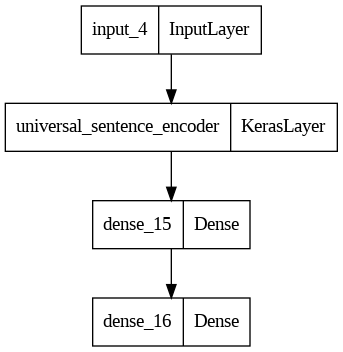

In [90]:
from tensorflow.keras.utils import plot_model
plot_model(model_1)

In [91]:
model_1.fit(train_sample_dataset,
            steps_per_epoch=len(train_sample_dataset),
            epochs=3,
            validation_data=valid_sample_dataset,
            validation_steps=len(valid_sample_dataset))

Epoch 1/3
400/400 [==============================] - 5s 9ms/step - loss: 0.5110 - accuracy: 0.7595 - val_loss: 0.4636 - val_accuracy: 0.7900
Epoch 2/3
400/400 [==============================] - 3s 9ms/step - loss: 0.4654 - accuracy: 0.7823 - val_loss: 0.4623 - val_accuracy: 0.7856
Epoch 3/3
400/400 [==============================] - 3s 8ms/step - loss: 0.4568 - accuracy: 0.7878 - val_loss: 0.4611 - val_accuracy: 0.7831


In [92]:
model_1_score = model_1.evaluate(valid_sample_dataset)[1]

print(f"model_1 score: {model_1_score}")

50/50 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.7831
model_1 score: 0.7831249833106995


> Model 2

- Pretrained token embeddings with character embeddings with basic neural network for the token embeddings and bidirectional LSTM for the character embeddings

In [65]:
def split_chars(text):
  return " ".join(list(text))

In [66]:
train_chars = [split_chars(sentence) for sentence in train_full['text'].tolist()]
val_chars = [split_chars(sentence) for sentence in val_full['text'].tolist()]
test_chars = [split_chars(sentence) for sentence in test_full['text'].tolist()]

train_sample_chars = [split_chars(sentence) for sentence in train_sample['text'].tolist()]
val_sample_chars = [split_chars(sentence) for sentence in val_sample['text'].tolist()]
test_sample_chars = [split_chars(sentence) for sentence in test_sample['text'].tolist()]

In [67]:
print(train_chars[0])

@ J e s s i c a K n o w s   I   u s e   i t   a n d   d o   l i k e   i t .  


In [97]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_full['text'].tolist(), train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_full['text'].tolist(), val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_sample_char_token_data = tf.data.Dataset.from_tensor_slices((train_sample['text'].tolist(), train_sample_chars))
train_sample_char_token_labels = tf.data.Dataset.from_tensor_slices(train_sample_labels_one_hot)
train_sample_char_token_dataset = tf.data.Dataset.zip((train_sample_char_token_data, train_sample_char_token_labels))
train_sample_char_token_dataset = train_sample_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_sample_char_token_data = tf.data.Dataset.from_tensor_slices((val_sample['text'].tolist(), val_sample_chars))
val_sample_char_token_labels = tf.data.Dataset.from_tensor_slices(val_sample_labels_one_hot)
val_sample_char_token_dataset = tf.data.Dataset.zip((val_sample_char_token_data, val_sample_char_token_labels))
val_sample_char_token_dataset = val_sample_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
# Calculating the average character length of text
import numpy as np

char_lens = [len(sentence) for sentence in train_full['text'].tolist()]
mean_char_len = np.mean(char_lens)
mean_char_len

74.1062984375

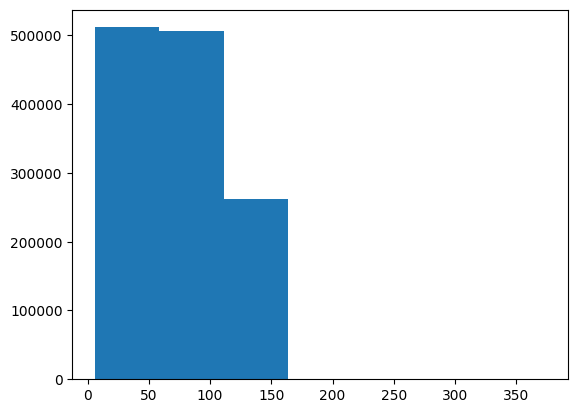

In [69]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [70]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

136

In [75]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [79]:
from tensorflow.keras.layers import TextVectorization

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_sample_chars)

In [80]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [93]:
# Part 1: Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Part 2: Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(2, activation="softmax")(final_dropout)

model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_char_embeddings")

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [94]:
model_2.summary()

Model: "model_2_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 136)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

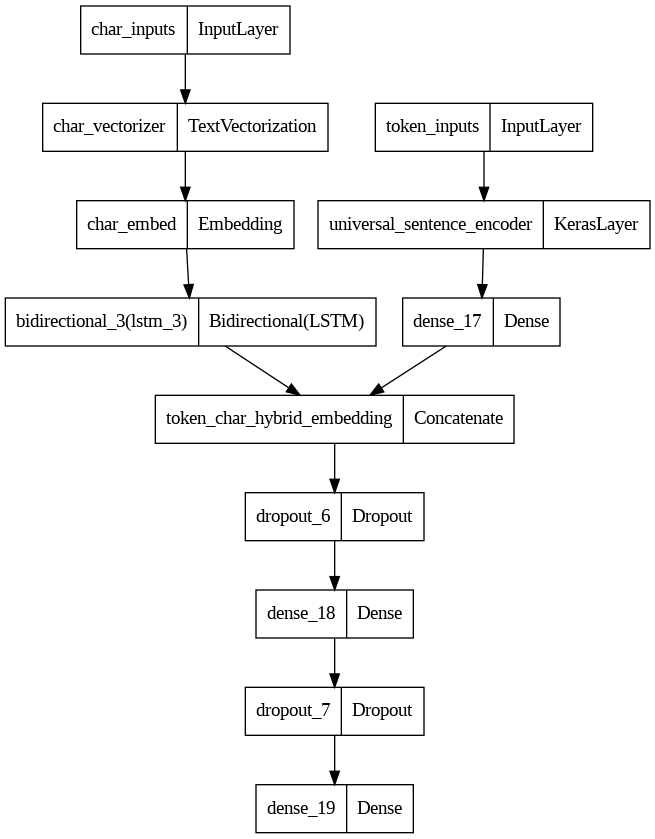

In [95]:
plot_model(model_2)

In [98]:
model_2.fit(train_sample_char_token_dataset,
            steps_per_epoch=len(train_sample_char_token_dataset),
            epochs=3,
            validation_data=val_sample_char_token_dataset,
            validation_steps=len(val_sample_char_token_dataset))

Epoch 1/3
400/400 [==============================] - 30s 60ms/step - loss: 0.5243 - accuracy: 0.7447 - val_loss: 0.4623 - val_accuracy: 0.7937
Epoch 2/3
400/400 [==============================] - 23s 57ms/step - loss: 0.4693 - accuracy: 0.7825 - val_loss: 0.4575 - val_accuracy: 0.7912
Epoch 3/3
400/400 [==============================] - 23s 56ms/step - loss: 0.4519 - accuracy: 0.7940 - val_loss: 0.4593 - val_accuracy: 0.7912


In [99]:
model_2_score = model_2.evaluate(val_sample_char_token_dataset)[1]

print(f"model_2 score: {model_2_score}")

50/50 [==============================] - 1s 20ms/step - loss: 0.4593 - accuracy: 0.7912
model_2 score: 0.7912499904632568


> Token Embedding Only vs Token Embedding + Character Embedding

- It can be observed that using both Token Embedding and Character Embedding outperforms using only Token Embedding

> Model 3

- Pretrained token embeddings with character embeddings with bidirectional LSTM network for the token embeddings and bidirectional LSTM for the character embeddings

In [108]:
# Part 1: Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_embeddings_expanded = layers.Reshape((1, -1))(token_embeddings)
token_outputs = layers.Bidirectional(layers.LSTM(64))(token_embeddings_expanded)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Part 2: Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(2, activation="softmax")(final_dropout)

model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_char_embeddings")

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [109]:
model_3.fit(train_sample_char_token_dataset,
            steps_per_epoch=len(train_sample_char_token_dataset),
            epochs=3,
            validation_data=val_sample_char_token_dataset,
            validation_steps=len(val_sample_char_token_dataset))

Epoch 1/3
400/400 [==============================] - 31s 59ms/step - loss: 0.5174 - accuracy: 0.7441 - val_loss: 0.4684 - val_accuracy: 0.7844
Epoch 2/3
400/400 [==============================] - 22s 55ms/step - loss: 0.4674 - accuracy: 0.7827 - val_loss: 0.4650 - val_accuracy: 0.7887
Epoch 3/3
400/400 [==============================] - 22s 56ms/step - loss: 0.4580 - accuracy: 0.7870 - val_loss: 0.4629 - val_accuracy: 0.7819


In [110]:
model_3_score = model_3.evaluate(val_sample_char_token_dataset)[1]

print(f"model_3 score: {model_3_score}")

50/50 [==============================] - 1s 18ms/step - loss: 0.4629 - accuracy: 0.7819
model_3 score: 0.7818750143051147


> Dense vs Bidirectional LSTM for Pretrained Embedding

- For a pretrained embedding, using more complex model such as bidirectional LSTM worsened the performance, possibily due to overfitting

> Model 4

- Using BERT

In [111]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00


In [124]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import pandas as pd

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
texts = train_sample['text'].tolist()
labels = pd.get_dummies(train_sample['polarity']).values.tolist()

input_encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
input_dataset = tf.data.Dataset.from_tensor_slices((dict(input_encodings), labels))

train_size = int(0.8 * len(input_dataset))
val_size = len(input_dataset) - train_size

train_dataset = input_dataset.take(train_size).batch(8)
val_dataset = input_dataset.skip(train_size).batch(8)

model_4 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
history_4 = model_4.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
128/128 [==============================] - 122s 957ms/step - loss: 0.2576 - accuracy: 0.8896 - val_loss: 0.6044 - val_accuracy: 0.7578
Epoch 2/3
128/128 [==============================] - 120s 938ms/step - loss: 0.2826 - accuracy: 0.8867 - val_loss: 0.7637 - val_accuracy: 0.7227
Epoch 3/3
128/128 [==============================] - 120s 937ms/step - loss: 0.2451 - accuracy: 0.9121 - val_loss: 0.7199 - val_accuracy: 0.7695


In [140]:
model_4_score = model_4.evaluate(val_dataset)[1]

print(f"model_4 score: {model_4_score}")

320/320 [==============================] - 79s 247ms/step - loss: 0.6057 - accuracy: 0.7926
model_4 score: 0.7925781011581421


In [141]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-27 08:36:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-27 08:36:15 (66.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [142]:
from helper_functions import plot_loss_curves

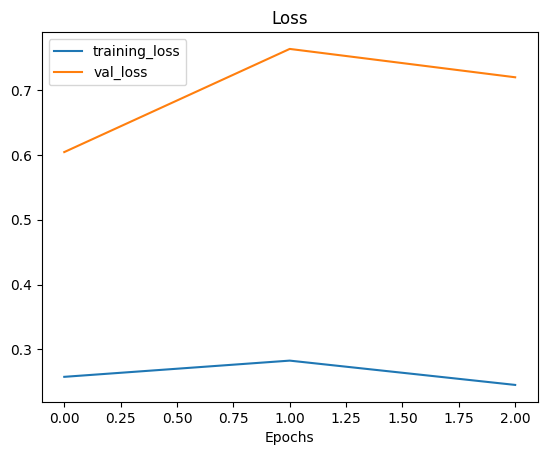

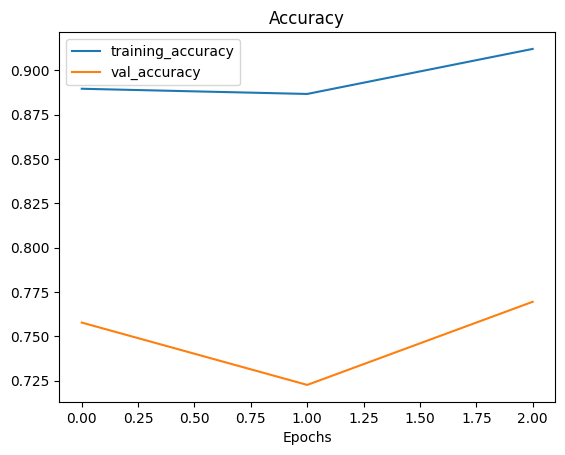

In [143]:
plot_loss_curves(history_4)

> Model 5

- Using SVM

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

X = train_sample['text']
y = train_sample['polarity'].map({0: 0, 4: 1})

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model_5 = svm.SVC()
model_5.fit(X_train, y_train)

SVC()

In [149]:
model_5_score = model_5.score(X_test, y_test)

print(f"model_5 score: {model_5_score}")

model_5 score: 0.76015625


# Comparing Models

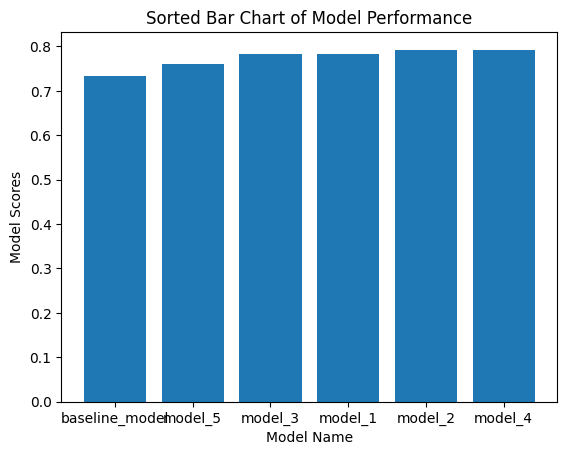

In [150]:
import matplotlib.pyplot as plt

model_scores = [model_0_score, model_1_score, model_2_score, model_3_score, model_4_score, model_5_score]

labels = ['baseline_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5']

sorted_indices = sorted(range(len(model_scores)), key=lambda k: model_scores[k])

sorted_model_scores = [model_scores[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.bar(sorted_labels, sorted_model_scores)

plt.xlabel('Model Name')

plt.ylabel('Model Scores')

plt.title('Sorted Bar Chart of Model Performance')

plt.show()


> Conclusion

- The BERT model performed the best, followed by Combined Embedding model, Combined Embedding model with Bidirectional LSTM, Token Embedding model, SVC model, and then the baseline model (Multinomial Naive Bayes)